<a href="https://colab.research.google.com/github/hunorxilard/onkutfel_2020-21/blob/szili_dolga/kicsi_heatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#download section
!wget https://github.com/hunorxilard/onkutfel_2020-21/blob/main/small_opt.h5?raw=True
!wget https://github.com/hunorxilard/onkutfel_2020-21/blob/main/real_and_fake_face_small.zip?raw=True
!unzip ./real_and_fake_face_small.zip?raw=True

In [2]:
#import basic stuff
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from google.colab.patches import cv2_imshow

In [3]:
#import tensorflow stuff
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image

In [56]:
#load model
model = tf.keras.models.load_model('small_opt.h5?raw=True')

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
activation_18 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_19 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 34, 34, 32)       

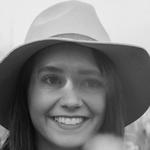

In [88]:
#show image
ORIGINAL = '/content/real_and_fake_face_small/training_fake/easy_28_1100.jpg'
DIM = 150

img = image.load_img(ORIGINAL, target_size=(DIM, DIM))

cv2_imshow(cv2.imread(ORIGINAL, cv2.IMREAD_GRAYSCALE))

In [89]:
#preprocess input
def create_preprocessed_data():
  training_data = []
  img_array = cv2.imread(ORIGINAL, cv2.IMREAD_GRAYSCALE)
  training_data.append([img_array,0])
  X=[]
  y=[]
  for features, label in training_data:
    X.append(features)
    y.append(label)
  X=np.array(X).reshape(-1,150,150,1)
  return X

x = create_preprocessed_data()

In [90]:
#predict
prediction = model.predict(x)
print(prediction)

[[6.3883417e-12]]


In [91]:
#Grad-CAM process
with tf.GradientTape() as tape:
  last_conv_layer = model.get_layer('conv2d_12')
  iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)

In [92]:
print(heatmap)

tf.Tensor(
[[[ 3.0837759e-14  3.0719669e-14  3.0951035e-14 ...  3.0677114e-14
    3.0678846e-14  3.0755482e-14]
  [ 3.0883838e-14  3.0721926e-14  3.1018946e-14 ...  3.0690897e-14
    3.0685950e-14  3.0628054e-14]
  [ 3.0863580e-14  3.0685019e-14  3.1059407e-14 ...  3.0706442e-14
    3.0622467e-14  3.0558289e-14]
  ...
  [-2.7771288e-15 -1.5807120e-14 -3.3690672e-15 ...  2.3616942e-14
    2.1260083e-14  1.5070497e-14]
  [-1.4084790e-14 -1.7114673e-14 -3.6182444e-15 ...  2.2502982e-14
    1.7245659e-14  1.2738254e-14]
  [-2.4992468e-14 -1.3358563e-14 -9.5105823e-16 ...  2.4277621e-14
    1.7394355e-14  1.2114870e-14]]], shape=(1, 34, 34), dtype=float32)


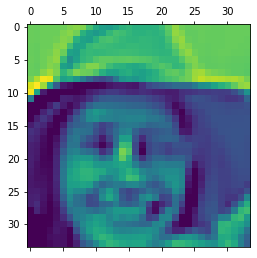

In [93]:
#visualize heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((34, 34))
plt.matshow(heatmap)
plt.show()

In [94]:
#cover
img = cv2.imread(ORIGINAL)

INTENSITY = 0.5
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

img = heatmap * INTENSITY + img

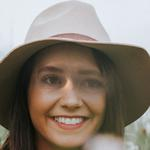

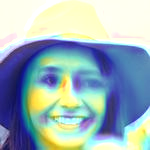

In [95]:
cv2_imshow(cv2.imread(ORIGINAL))
cv2_imshow(img)